# Project

"Web Gallery Of Art" URL

In [1]:
url = "https://www.wga.hu"

---
Get chromium and chromedriver paths

In [2]:
import os

chromium_path = os.environ.get("CHROMIUM")
chromedriver_path = os.environ.get("CHROMEDRIVER")

print(chromium_path)
print(chromedriver_path)

/nix/store/jgirpvwnpnxjydg9iyfhkl237jdhlzqd-chromium-120.0.6099.224/bin/chromium
/nix/store/xivj3pjvcasjr1h53v4k82kv5q5wq68d-chromedriver-120.0.6099.109/bin/chromedriver


---
Setup selenium driver

In [3]:
from selenium import webdriver

options = webdriver.ChromeOptions()
options.binary_location = chromium_path
service = webdriver.ChromeService(chromedriver_path)
driver = webdriver.Chrome(service=service, options=options)

Get list of available periods

In [4]:
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select

driver.get(url+"/index_artists.html")
driver.switch_to.frame(driver.find_element(By.NAME, "MAIN"))
period_select = Select(driver.find_element(By.NAME, "Period"))
period_list = list(map(lambda p: p.text, period_select.options))

Get results of all renaissance periods

In [5]:
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
import time

driver.get(url+"/index_artists.html")

renaissance_results = {}

for item in period_list:
    if "Renaissance" in item:
        driver.switch_to.frame(driver.find_element(By.NAME, "MAIN"))
        period_select = Select(driver.find_element(By.NAME, "Period"))

        period_select.select_by_visible_text(item)

        submit_button = driver.find_element(By.CSS_SELECTOR, 'input[type="SUBMIT"]')
        submit_button.click()

        renaissance_results[item] = driver.page_source.encode("utf-8")
        
        time.sleep(1)

        driver.back()

driver.quit()

Get all pages for each renaissance period

In [6]:
import requests
from bs4 import BeautifulSoup

renaissance_pages = {}

for name, source in renaissance_results.items():
    soup = BeautifulSoup(source, "html.parser")

    pagenum_div = soup.find_all("div", class_="PAGENUM")[1] # Take only one since both are the same
    page_anchors = pagenum_div.find_all("a", string=lambda text: text and text.isdigit())

    pages = []
    
    for anchor in page_anchors:
        page_url = url + anchor["href"]
        response = requests.get(page_url)
        if response.status_code == 200:
            print("OK")
        pages.append(response.content)

    renaissance_pages[name] = pages
    

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK


## Get data of each artist

Artwork class

In [7]:
class Artwork:
    def __init__(self, name):
        self.name = name

Artist class

In [8]:
class Artist:
    def __init__(self, name, nationality, period, specialization):
        self.name = name
        self.nationality = nationality
        self.specialization = specialization
        self.period = period
        self.artworks = []

    def add_artwork(self, artwork):
        self.artworks.append(artwork)

In [9]:
def is_artwork_table(tag):
    return tag.name == "table" and tag.get("bgcolor") == "#99cccc"

In [10]:
import re

def extract_sp(text):
    match = re.match(r'^\w+\s*(.*?)\s*\(', text)

    if match:
        return match.group(1)
    else:
        return " ".join(text.split()[1:])


In [14]:
from bs4 import BeautifulSoup
import requests

artists = []

for period, pages in renaissance_pages.items():
    for page in pages:
        soup = BeautifulSoup(page, "html.parser")

        div = soup.find("div", class_='PAGENUM')
        table = div.find("table")
        
        for row in table.find_all("tr")[1:]:
            columns = row.find_all(["td", "th"])[1:]
            
            artist_name = columns[0].find("b").text

            # Skip if this is a duplicate
            if "(see" in artist_name:
                continue

            nationality = columns[-1].text.split(" ")[0].strip()
            specialization = extract_sp(columns[-1].text)
                
            artist = Artist(artist_name, nationality, period, specialization)

            artwork_page_url = columns[0].find("a").get("href")
            # print(artist_name)
            # artworks = collect_artworks(artwork_page_url, [])
            # print("Artwork_test:", artworks[0])
            response = requests.get(artwork_page_url)
            soup_ = BeautifulSoup(response.content, "html.parser")
            table_ = soup_.find(is_artwork_table)

            
            
            if table_ is not None:
                for row_ in table_.find_all("tr")[1:]:
                    data = row_.find_all(["td", "th"])[1]
                    artwork_name = data.find("b").text
                    artist.add_artwork(Artwork(artwork_name))
                    print(artwork_name)
            else:
                list = soup_.find("ul")
                for item in list.find_all("a"):
                    artworks_url = item.get("href")
                    artworks_url = artwork_page_url[:artwork_page_url.rfind("/")+1] + artworks_url
                    response = requests.get(artworks_url)
                    soup_ = BeautifulSoup(response.content, "html.parser")
                    table_ = soup_.find(is_artwork_table)

                    if table_ is None:
                        break
                    
                    for row_ in table_.find_all("tr")[1:]:
                        data = row_.find_all(["td", "th"])[1]
                        artwork_name = data.find("b").text
                        artist.add_artwork(Artwork(artwork_name))
                        print(artwork_name)
            
            artists.append(artist)

The Archangel Michael
Elector Frederick III of Saxony, Called Frederick the Wise
Medal of Ferdinand II
Giovanni Gioviano Pontano
Giovanni Gioviano Pontano
Giovanni Gioviano Pontano
Venus
Virgin Enthroned between Sts John the Baptist and Anthony of Padua
Lunette and predella
Adoration of the Magi
Sts Sebastian and Roch
St Jerome in the Desert
Nativity
Nativity
Nativity
Sacred Representation with Sts Francis, Anthony of Padua and Bernardino
Mary Magdalene
Interior view
View of the Cappella di San Sigismondo
Cappella di San Sigismondo (detail)
Cappella di San Sigismondo (detail)
Cappella di San Sigismondo (detail)
Cappella di San Sigismondo (detail)
Cappella di San Sigismondo (detail)
Cappella di San Sigismondo (detail)
Cappella di San Sigismondo (detail)
Cappella di San Sigismondo (detail)
Cappella di San Sigismondo (detail)
Cappella di San Sigismondo (detail)
View of the Cappella dei Martiri
Cappella dei Martiri (detail)
Cappella dei Martiri (detail)
Cappella dei Martiri (detail)
Cappel

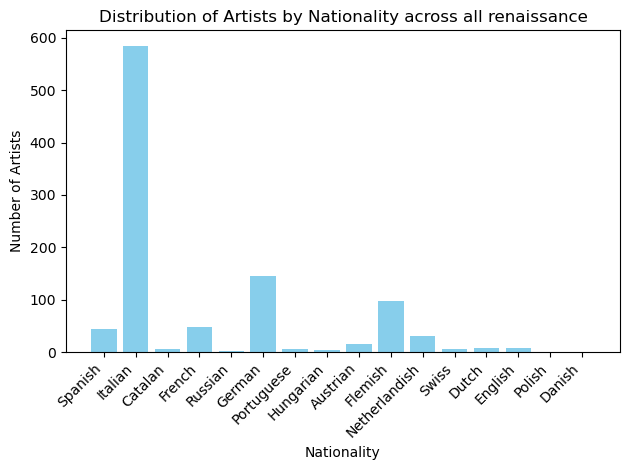

In [16]:
import matplotlib.pyplot as plt
from collections import Counter


nationality_counts = Counter(artist.nationality for artist in artists)
nationalities = nationality_counts.keys()
counts = nationality_counts.values()

plt.bar(nationalities, counts, color='skyblue')
plt.xlabel('Nationality')
plt.ylabel('Number of Artists')
plt.title('Distribution of Artists by Nationality across all renaissance')

plt.xticks(rotation=45, ha='right')
plt.tight_layout() 

plt.show()

## Distribution of artists by nationality in each renaissance period

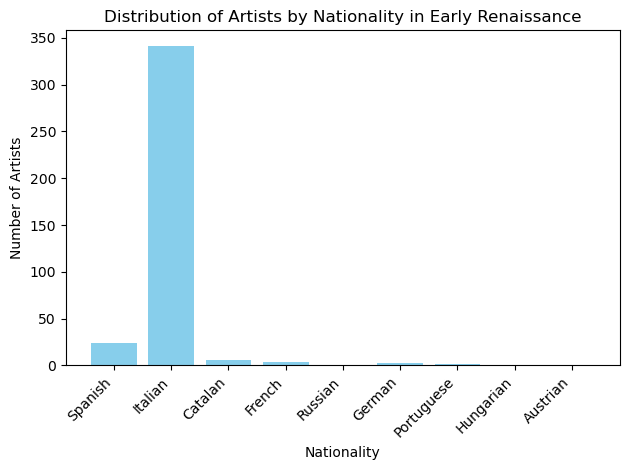

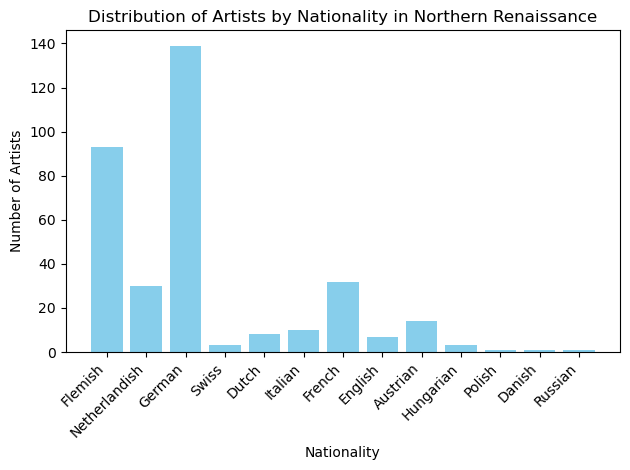

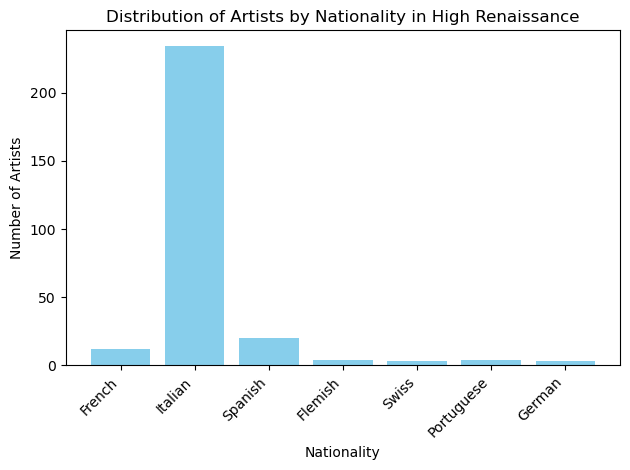

In [17]:
import matplotlib.pyplot as plt
from collections import defaultdict

artists_by_period = defaultdict(list)
for artist in artists:
    artists_by_period[artist.period].append(artist)

# Create separate bar charts for each period
for period, period_artists in artists_by_period.items():
    nationality_counts = Counter(artist.nationality for artist in period_artists)
    nationality_counts.pop(None)
    nationalities = nationality_counts.keys()
    counts = nationality_counts.values()

    plt.figure()  # Create a new figure for each period
    plt.bar(nationalities, counts, color='skyblue')
    plt.xlabel('Nationality')
    plt.ylabel('Number of Artists')
    plt.title(f'Distribution of Artists by Nationality in {period}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    plt.show()

## distribution of artists by specialization in each renaissance period

In [18]:
specialization_counts = Counter(artist.specialization for artist in artists)

for specialization, count in specialization_counts.items():
    print(f"Specialization: {specialization}, Count: {count}")

Specialization: painter, Count: 568
Specialization: sculptor, Count: 198
Specialization: architect, Count: 103
Specialization: illuminator, Count: 40
Specialization: graphic artist, Count: 53
Specialization: glass painter, Count: 7
Specialization: goldsmith, Count: 21
Specialization: potter, Count: 6
Specialization: tapestry weaver, Count: 5
Specialization: miniaturist, Count: 3
Specialization: cabinet-maker, Count: 1


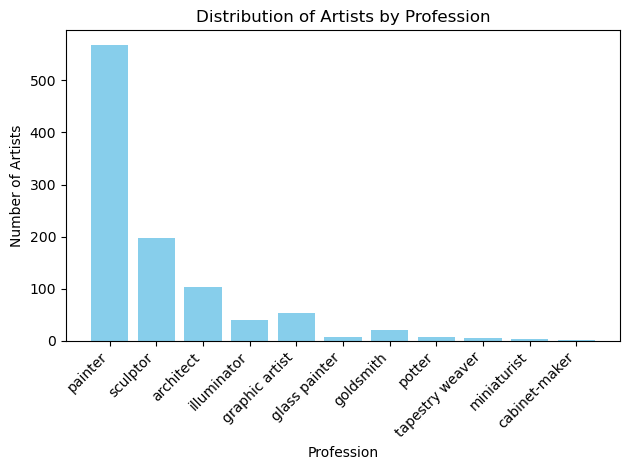

In [22]:
import matplotlib.pyplot as plt
from collections import Counter

specialization_counts = Counter(artist.specialization for artist in artists)

# for specialization, count in specialization_counts.items():
#     print(f"Specialization: {specialization}, Count: {count}")

specializations = specialization_counts.keys()
counts = specialization_counts.values()

plt.bar(specializations, counts, color='skyblue')
plt.xlabel('Profession')
plt.ylabel('Number of Artists')
plt.title('Distribution of Artists by Profession')

plt.xticks(rotation=45, ha='right')
plt.tight_layout() 

plt.show()

## Top artists with most artworks from each specialization

In [20]:
def get_most_artistic_per_specialization(artists):
    specialization_dict = defaultdict(lambda: {'artist': None, 'artwork_count': 0})

    for artist in artists:
        specialization = artist.specialization
        artwork_count = len(artist.artworks)

        if artwork_count > specialization_dict[specialization]['artwork_count']:
            specialization_dict[specialization]['artist'] = artist
            specialization_dict[specialization]['artwork_count'] = artwork_count

    result_dict = {spec: data['artist'] for spec, data in specialization_dict.items()}
    return result_dict

In [21]:
results = get_most_artistic_per_specialization(artists)

for specialization, artist in results.items():
    print(specialization, artist.name, len(artist.artworks))

painter CRANACH, Lucas the Elder 339
sculptor QUERCIA, Jacopo della 104
architect PALLADIO, Andrea 75
illuminator LIMBOURG brothers (Herman, Jean, Paul) 25
graphic artist RAIMONDI, Marcantonio 24
glass painter VELLERT, Dirck Jacobsz. 5
goldsmith CELLINI, Benvenuto 83
potter PALISSY, Bernard 4
tapestry weaver DERMOYEN, Willem 2
miniaturist LIMOSIN, Léonard 8
cabinet-maker WALDNER, Hans 4


In [23]:
artwork_count = 0

for artist in artists:
    artwork_count += len(artist.artworks)

print (artwork_count)


11584
